### Preprocessing: finding toxic n-grams in Wikipedia dataset

For each n-gram up to n=3, we consider:
- $N_t$ = number of appearances in comments marked toxic
- $N_n$ = number of appearances in comments not marked toxic

We then consider the ratio $\frac{N_t}{N_t+N_n}$ as a measure of toxicity of a particular n-gram. The following code looks for most toxic n-grams up to n=3 in the Wikipedia dataset.

In [1]:
%%capture
import utils
import pandas as pd

In [2]:
# Step 1: collect n-grams from data
train = pd.read_csv('data/toxic_train.csv')
train_toxic = train[train['toxic']==1]

# this takes a few minutes
words, bigrams, trigrams = utils.get_ngrams(train['comment_text'], train['toxic'])

Progress: 159571 / 159571

In [3]:
# Step 2: compute frequencies
freqs_one = utils.get_frequencies(words, threshold=200)
freqs_two = utils.get_frequencies(bigrams, threshold=100)
freqs_three = utils.get_frequencies(trigrams, threshold=50)

In [4]:
# Step 3: print top N n-grams
from operator import itemgetter
N = 10
print("%-*s %-*s %-*s" % (40, "Word", 20, "Toxicity ratio", 20, "Occurences"))
for key in dict(sorted(freqs_one.items(), key = itemgetter(1), reverse = True)[:N]):
    print("%-*s %-*.1f %-*d" % (40, key, 20, freqs_one[key], 20, words[key][1]))
print("------")

for key in dict(sorted(freqs_two.items(), key = itemgetter(1), reverse = True)[:N]):
    print("%-*s %-*.1f %-*d" % (40, key, 20, freqs_two[key], 20, bigrams[key][1]))
print("------")

for key in dict(sorted(freqs_three.items(), key = itemgetter(1), reverse = True)[:N]):
    print("%-*s %-*.1f %-*d" % (40, key, 20, freqs_three[key], 20, trigrams[key][1]))

Word                                     Toxicity ratio       Occurences          
cocksucker                               1.0                  548                 
mothjer                                  1.0                  489                 
cocksucking                              1.0                  290                 
niggas                                   1.0                  345                 
cuntbag                                  1.0                  226                 
securityfuck                             1.0                  227                 
fggt                                     1.0                  477                 
sexsex                                   1.0                  332                 
hanibal911you're                         1.0                  366                 
buttsecks                                1.0                  498                 
------
you faggot                               1.0                  115               

***

### Emoji analysis

We investegated the influence of emoji presence on tweet deletion rate for the Twitter dataset. The difference turned out to be very minor and not statistically significant.

Deletion rate is about 11.6% for tweets with emojis and about 10.8% for those without emojis.

In [5]:
# Compute deletion rates for tweets with and without emojis
def emojiDetection(x):
    return '\\x' in x

df = pd.read_csv('data/sample_with_label.csv')
df['emoji'] = df['TweetText'].apply(emojiDetection)

emoji_no_del = len(df[(df['emoji'] == True) & (df['WasDeleted'] == 0)])
no_emoji_no_del = len(df[(df['emoji'] == False) & (df['WasDeleted'] == 0)])
emoji_del = len(df[(df['emoji'] == True) & (df['WasDeleted'] == 1)])
no_emoji_del = len(df[(df['emoji'] == False) & (df['WasDeleted'] == 1)])

print("Deletion rate for tweets with emojis = %.3f" % (emoji_del/(emoji_no_del + emoji_del)))
print("Deletion rate for tweets without emojis = %.3f" % (no_emoji_del/(no_emoji_no_del + no_emoji_del)))

Deletion rate for tweets with emojis = 0.116
Deletion rate for tweets without emojis = 0.108


***

### Time of day analysis

We investigated the influence of the time of day on the number of deleted tweets. The code below produces a plot of deleted tweets in relation to 24-hour time of day and the same for tweets that were not deleted. Since the graphs look almost identical (except the scaled y-axis), we conclude that time of day is not a significant factor in deletion rates.

Deleted tweets by time of day:


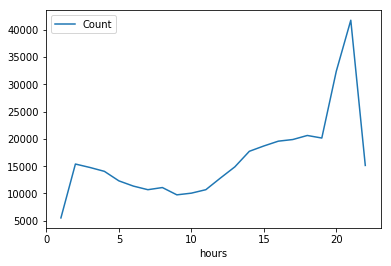

In [7]:
import re
import datetime

def hourify(s):
    start = s.find(' ')
    end = s.find(':')
    return int(s[start:end])

df = pd.read_csv('data/sample_with_label.csv')
df['hours'] = df['TweetDateTime'].apply(hourify)
df_grouped = df.groupby(['WasDeleted', 'hours']).size().reset_index()
df_grouped = df_grouped.rename({0: 'Count'}, axis=1)

print('Deleted tweets by time of day:')
df_grouped[df_grouped['WasDeleted']==0].plot(x = 'hours', y = 'Count')

Non-deleted tweets by time of day:


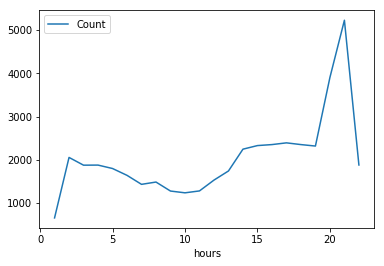

In [8]:
print('Non-deleted tweets by time of day:')
df_grouped[df_grouped['WasDeleted']==1].plot(x = 'hours', y = 'Count')

***

### First try: a Naive Bayes model for toxicity prediction

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
#import numpy as np
%matplotlib inline

In [10]:
# Load data and train model on Wikipedia dataset
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
df = pd.read_csv('data/toxic_train.csv')
X = df['comment_text']
y = df['toxic']
text_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [11]:
# example predictions
print('you suck and I fucking hate you - %.3f ' % text_clf.predict_proba(['you suck and I fucking hate you'])[0,1])
print('that was great, thank you - %.3f ' % text_clf.predict_proba(['that was great, thank you'])[0,1])

you suck and I fucking hate you - 0.962 
that was great, thank you - 0.003 


In [12]:
# predict toxic probability for Twitter dataset
twitter_df = pd.read_csv('data/sample_with_label.csv')
twitter_df.columns = ['Index','TweetID','ScreenName','TweetText','TweetDateTime','Followers','UserID','WasDeleted']
twitter_df['ToxicityProba'] = text_clf.predict_proba(twitter_df['TweetText'])[:,1]
twitter_df = twitter_df.sort_values(by=['ToxicityProba'],ascending=False)
twitter_df.head()

,Index,TweetID,ScreenName,TweetText,TweetDateTime,Followers,UserID,WasDeleted,ToxicityProba
243293,243293,1245363598425313280,reefdude001,b'fuck shit bitch ass damn fucker tits cock wh...,2020-04-01 14:53:14,46,375348881,0,0.999824
132607,132607,1245240647910473728,theatreryoko,b'@shintsukimiai OKAY I JUST HOPE TWITTER DOES...,2020-04-01 06:44:40,65,1211650395275022336,0,0.999804
101208,101208,1245206990462345216,nolan_lacke,b'@Ronnie2K I love you man you are the best......,2020-04-01 04:30:56,45,766664388795400193,0,0.999804
100268,100268,1245206103111106561,JeffreyEAran,"b'Ohhhhh\nFuck, shit, bitch, damn, cock sucker...",2020-04-01 04:27:24,141,1174801703998283776,0,0.999793
218479,218479,1245344179057766404,starsburst,b'fuck you uglyass rat shit bastard stupid fuc...,2020-04-01 13:36:04,30,1238281735042994178,0,0.999705


In [13]:
# assess performance
import utils

n = 500
twitter_df['IsResponseTweet'] = twitter_df['TweetText'].apply(utils.is_response_tweet)
response_tweets_df = twitter_df[twitter_df['IsResponseTweet']]
print('Top', n, 'deletion rate:', response_tweets_df.head(n)['WasDeleted'].values.sum()/n)
print('Bottom', n, 'deletion rate:', response_tweets_df.tail(n)['WasDeleted'].values.sum()/n)

Top 500 deletion rate: 0.218
Bottom 500 deletion rate: 0.06


***

### Neural network model performance on Twitter data

After training a GRU-based model on the Wikipedia data, we test its toxicity prediction performance on the Twitter dataset. The metric used is the following: we sort the tweets by our model's toxicity prediction scores and take the top $n$ and bottom $n$ cutoff sets, then compute deletion rates for both. We would like to see a high deletion rate for the top $n$ tweets and a low deletion rate for the bottom $n$ tweets.

In [14]:
%%capture
import utils
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing import sequence
import pandas as pd
pd.options.mode.chained_assignment = None

In [15]:
# Import datasets
X_train, y_train, X_test = utils.load_wiki_data()
twitter_df, twitter_text, twitter_y = utils.load_twitter_data()

# Tokenization of input, takes about a minute
print("Tokenizing, please wait ...")
tokenizer = utils.initialize_tokenizer(list(X_train)+list(X_test)+list(twitter_text))
x_train = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
x_test = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)
twitter_tokenized = sequence.pad_sequences(tokenizer.texts_to_sequences(twitter_text), maxlen=100)
print("Tokenizing completed.")

Tokenizing, please wait ...
Tokenizing completed.


In [16]:
# Make predictions on the Twitter dataset
from tensorflow.keras.models import load_model

# uncomment to use different saved model:
model = load_model("data/models/model_twitter_only.h5")
#model = load_model("data/models/model_wiki_only.h5")
#model = load_model("data/models/model_wiki_and_twitter.h5")

tw_train_df, tw_test_df, twy_train, twy_test = train_test_split(twitter_df, twitter_y, test_size=0.25, random_state=42)
tw_train, tw_val, twy_train, twy_val = train_test_split(twitter_tokenized, twitter_y, test_size=0.25, random_state=42)

tw_test_df['IsResponseTweet'] = tw_test_df['TweetText'].apply(utils.is_response_tweet)
tw_test_df['ToxicityProba'] = model.predict(tw_val, verbose=1, batch_size=1024)
tw_test_df = tw_test_df.sort_values(by=['ToxicityProba'],ascending=False)
response_tweets_df = tw_test_df[tw_test_df['IsResponseTweet']]

101037/101037 [==============================] - 25s 251us/sample


In [17]:
# Asses performance on Twitter dataset
n = 500
print('Top', n, 'deletion rate:', response_tweets_df.head(n)['WasDeleted'].values.sum()/n)
print('Bottom', n, 'deletion rate:', response_tweets_df.tail(n)['WasDeleted'].values.sum()/n)

Top 500 deletion rate: 0.552
Bottom 500 deletion rate: 0.04
